# Breast Cancer Classifying With Deep Learning

Author: **Marcin Sikorski**<br>
Date: March, 2023

Update of binary classification problem. The classification will be performed with deep learning in <code>Tensorflow</code> and <code>Keras</code>.

**Data Source:** [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic))

**Table of Contents:**
1. Loading Dataset<br>
2. Standardizing and Splitting Data<br>
3. Training First ANN: All Features<br>
4. Training Second ANN: With Dimensionality Reduction<br>
5. Evaluating and Visualizing Model Performance<br>
6. Conclusions<br>
7. Bonus: Visualizing Neural Network

### 1. Loading Dataset

We will download data directly from UCI Machine Learning Repository website, add a header, and make appropriate data wrangling for resulting dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import data
def load_data():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
    dataframe = pd.read_csv(url, sep=',', header=None)
    
    header = ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
              'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
              'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
              'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst',
              'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst',
              'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
    
    # add new column names to dataframe
    dataframe.columns = header
    
    # drop useless 'id' column
    dataframe = dataframe.drop('id', axis=1)
    
    # drop duplicates (if any)
    dataframe = dataframe.drop_duplicates(keep='last')
    
    # map labels (categorical values) into binary form
    dataframe = dataframe.replace({'B': 0, 'M': 1})
    
    return dataframe

df = load_data()
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
# summarize dataframe
def dataframe_shape():
    print('Number of samples (patients):', df.shape[0])
    print('Number of predictors:', df.shape[1] - 1)
    print('Number of NaN values:', df.isnull().sum().sum())
    
dataframe_shape()

Number of samples (patients): 569
Number of predictors: 30
Number of NaN values: 0


### 2. Standardizing and Splitting Data

We will apply variable standardization for better prediction results. Next, we will split our dataset into training and validation data with 70:30 ratio and then proceed into developing our classifying models.

In [3]:
# standardize and split data into train and test samples
def standard_split_data():
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    
    # scale data without target column
    sc = StandardScaler()
    sc.fit(df.drop('diagnosis', axis=1))
    
    global X, y, X_train, X_test, y_train, y_test
    
    # rescale (standardize) features without target column
    X = sc.transform(df.drop('diagnosis', axis=1))
    # target data y
    y = df['diagnosis']
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, shuffle=True, random_state=42)
    
    print('Train Data:', np.size(X_train, 0))
    print('Test Data:', np.size(X_test, 0))

standard_split_data()

Train Data: 398
Test Data: 171


### 3. Training First ANN: All Features

We will start by implementing an artificial neural network with all available attributes.

In [4]:
# define 1st ANN, evaluation metrics, optimizer for classifying
def first_model():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    
    # define classifying model
    classifier = Sequential(
        [
            # 1st hidden layer, input_dim=30
            Dense(units=9, kernel_initializer='he_uniform', activation='relu', input_dim=np.shape(X_train)[1]),
            
            # 2nd hidden layer
            Dense(units=9, kernel_initializer='he_uniform', activation='relu'),
            
            # last layer or output layer
            Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid')
        ]
        )
    
    from tensorflow.keras.metrics import BinaryAccuracy, AUC
        
    # metrics for evaluation
    eval_metrics = [BinaryAccuracy(name='accuracy'), AUC(name='AUC')]
        
    from tensorflow.keras.optimizers import Adam
    
    # define Adam optimizer and compile model
    adam_opt = Adam(learning_rate=0.001, beta_1=0.92, beta_2=0.999)
    classifier.compile(optimizer=adam_opt, loss='binary_crossentropy', metrics=eval_metrics)
    
    classifier._name = 'ANN_all_features'
    
    return classifier

# create a basic model instance
classifier_1 = first_model()

# display the model's architecture
classifier_1.summary()

Model: "ANN_all_features"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 279       
                                                                 
 dense_1 (Dense)             (None, 9)                 90        
                                                                 
 dense_2 (Dense)             (None, 1)                 10        
                                                                 
Total params: 379
Trainable params: 379
Non-trainable params: 0
_________________________________________________________________


In [5]:
# fit 1st ANN
history_all = classifier_1.fit(X_train, y_train, batch_size=100, epochs=100, verbose=0)

In [6]:
# make predictions (classification)
y_pred_1 = classifier_1.predict(X_test)

6/6 [==============================] - 0s 5ms/step


### 4. Training Second ANN: With Dimensionality Reduction

This time, we will reduce the dataset's dimensionality, provide them to our new artificial neural network, and compare the results. The reduction will be made using PCA. The concept is to eliminate any noisy or unnecessary data for classification improvement.

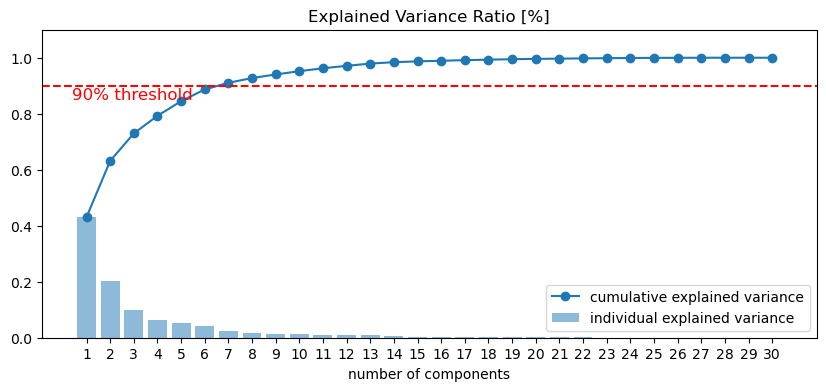

Number of components: 6


In [7]:
# find optimal number of components with explained variance (on X_train)
def pca_optimal_components():
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=None).fit(X_train)
    
    # percentage of variance explained by each of the selected components
    y = np.cumsum(pca.explained_variance_ratio_)
    
    # visualizing results
    plt.figure(figsize=(10, 4))
    plt.ylim(0.0, 1.1)
    
    plt.plot(range(1, X_train.shape[1]+1), y, marker='o', markersize=6, label='cumulative explained variance')
    plt.bar(range(1, X_train.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, label='individual explained variance')
    
    plt.title('Explained Variance Ratio [%]')
    plt.xlabel('number of components')
    
    plt.axhline(y=0.9, color='red', linestyle='--')
    plt.text(x=0.4, y=0.85, s='90% threshold', color='red', fontsize=12)
    plt.xticks(np.arange(1, X_train.shape[1]+1))
    plt.legend(loc='best')
    plt.show()
    
    print('Number of components:', np.sum(y < 0.9))

pca_optimal_components()

In [8]:
# perform dimensionality reduction with PCA on both X_train and X_test
def reduce_dimensionality(n_components, data):  
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=n_components).fit_transform(data)
    
    return pca

X_train_red = reduce_dimensionality(n_components=6, data=X_train)
X_test_red = reduce_dimensionality(n_components=6, data=X_test)

print('New shape of train data:', X_train_red.shape)
print('New shape of test data:', X_test_red.shape)

New shape of train data: (398, 6)
New shape of test data: (171, 6)


In [9]:
# define 2nd ANN, evaluation metrics, optimizer for classifying
def second_model():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    
    # define classifying model
    classifier = Sequential(
        [
            # 1st hidden layer, input_dim=6
            Dense(units=4, kernel_initializer='he_uniform', activation='relu', input_dim=np.shape(X_train_red)[1]),
            
            # 2nd hidden layer
            Dense(units=4, kernel_initializer='he_uniform', activation='relu'),
            
            # last layer or output layer
            Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid')
        ]
        )
    
    from tensorflow.keras.metrics import BinaryAccuracy, AUC
        
    # metrics for evaluation
    eval_metrics = [BinaryAccuracy(name='accuracy'), AUC(name='AUC')]
        
    from tensorflow.keras.optimizers import Adam
    
    # define Adam optimizer and compile model
    adam_opt = Adam(learning_rate=0.001, beta_1=0.92, beta_2=0.999)
    classifier.compile(optimizer=adam_opt, loss='binary_crossentropy', metrics=eval_metrics)
    
    classifier._name = 'ANN_red_features'
    
    return classifier

# create a basic model instance
classifier_2 = second_model()

# display the model's architecture
classifier_2.summary()

Model: "ANN_red_features"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 28        
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________


In [10]:
# fit 2nd ANN
history_red = classifier_2.fit(X_train_red, y_train, batch_size=100, epochs=150, verbose=0)

In [11]:
# make predictions with 2nd classifier
y_pred_2 = classifier_2.predict(X_test_red)

6/6 [==============================] - 0s 2ms/step


### 5. Evaluating and Visualizing Model Performance

At this stage, we will generate plots to compare the classifiers and print basic metrics.

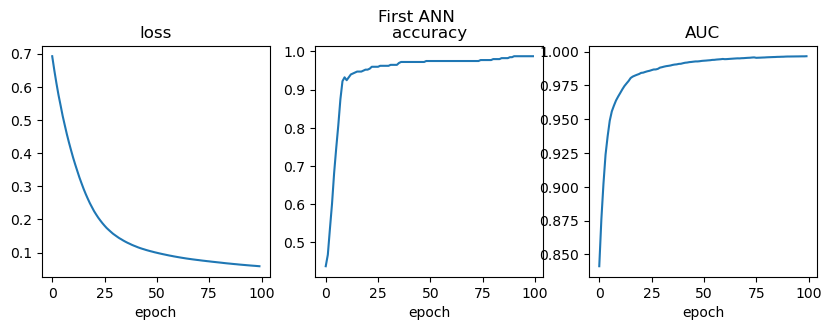

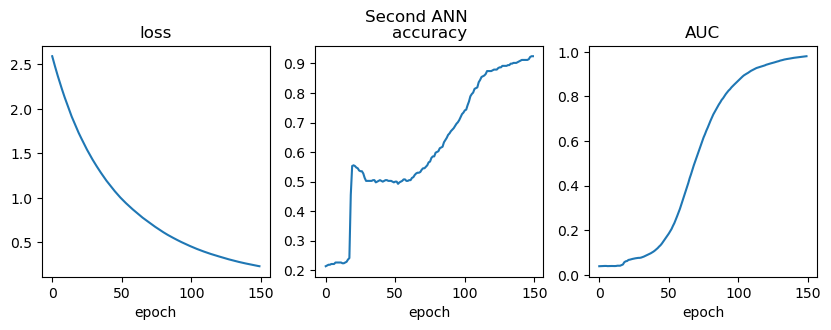

In [12]:
# plot learning curves for each classifier
def plot_learning_curves():
    metric_list =  ['loss', 'accuracy', 'AUC']
    
    ######### 1st classifier
    fig = plt.figure(figsize=(10, 3))
    fig.suptitle('First ANN', y=1.0)
    
    for i, metric in enumerate(metric_list):
        plt.subplot(1, 3, i+1)
        plt.plot(history_all.epoch, history_all.history[metric])
        plt.xlabel('epoch')
        plt.title(metric)
    plt.show()
    
    ######### 2nd classifier
    fig = plt.figure(figsize=(10, 3))
    fig.suptitle('Second ANN', y=1.0)
    
    for i, metric in enumerate(metric_list):
        plt.subplot(1, 3, i+1)
        plt.plot(history_red.epoch, history_red.history[metric])
        plt.xlabel('epoch')
        plt.title(metric)
    plt.show()

plot_learning_curves()

> Much better looking evaluation curves for first ANN (with all features).

In [13]:
# get basic evaluation scores for each classifier
def print_metrics():
    from sklearn.metrics import accuracy_score, precision_score, f1_score
    
    # initialize lists
    mod_list = [classifier_1._name, classifier_2._name]
    acc_list = []
    prec_list = []
    f1_list = []
    
    # get metrics for each ANN
    for i in [y_pred_1, y_pred_2]:
        acc_list.append(accuracy_score(y_test, (i > 0.5).astype(int), normalize=True) * 100)
        prec_list.append(precision_score(y_test, (i > 0.5).astype(int)) * 100)
        f1_list.append(f1_score(y_test, (i > 0.5).astype(int), average='binary') * 100)
    
    # dataframe to store evaluation metrics
    model_scores = pd.DataFrame({'Classifier': mod_list, 'Accuracy [%]': acc_list,
                                 'Precision [%]': prec_list, 'F1 Score [%]': f1_list})
    
    return model_scores.round(decimals=3).style.hide(axis='index')
    
print_metrics()

Classifier,Accuracy [%],Precision [%],F1 Score [%]
ANN_all_features,98.830000,98.413000,98.413000
ANN_red_features,96.491000,98.305000,95.082000


> Slightly higher scores for first classifier.

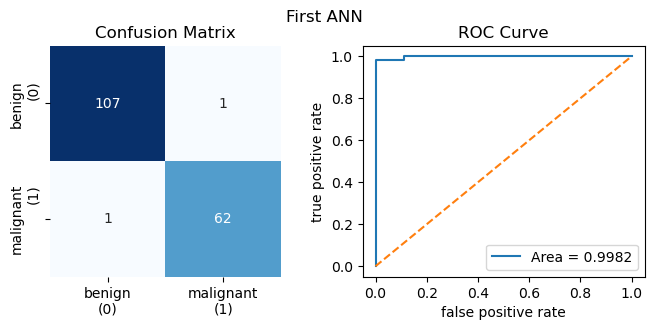

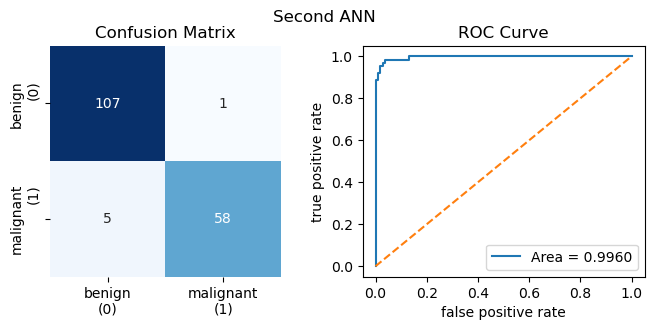

In [14]:
# more plots
def plot_confusion_roc():
    from sklearn.metrics import confusion_matrix
    from seaborn import heatmap
    from sklearn.metrics import roc_curve, auc
    
    # class labels for displaying
    class_labels = ['benign\n(0)', 'malignant\n(1)']
    
    # heatmap properties
    hm_kwargs = dict(cmap='Blues', square=True, annot=True, fmt='d', cbar=False,
                     xticklabels=class_labels, yticklabels=class_labels)
    
    # loop through predictions
    for i, title in zip([y_pred_1, y_pred_2], ['First ANN', 'Second ANN']):   
        fig = plt.figure(figsize=(8, 3))
        fig.suptitle(title, y=1.0)

        ######### plot confusion matrix
        plt.subplot(1, 2, 1)
        confu_matrix = confusion_matrix(y_test, y_pred=(i > 0.5).astype(int))
        heatmap(data=confu_matrix, **hm_kwargs)
        plt.title('Confusion Matrix')
        
        ######### plot ROC curve
        plt.subplot(1, 2, 2)
        fpr, tpr, thresholds = roc_curve(y_test, i)
        plt.plot(fpr, tpr, label='Area = {:.4f}'.format(auc(fpr, tpr)))
        plt.plot([0,1], [0, 1], linestyle='--')
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC Curve', size=12)
        plt.legend(loc='lower right')
    plt.show()
    
plot_confusion_roc()

> Still the ANN with all attributes has the best performance. This model has less missed class labels and the AUC score (area beneath the curve) is slightly higher. The ROC curves for both models are almost right angles.

### 6. Conclusions

In this repository, we performed a classification task for predicting cancer diagnosis based on given characteristics. To solve this problem we applied two artificial neural networks constructed in <code>Keras</code> with different approaches:
* introducing all possible features,
* with a dimensionality reduction.

This analysis proved that decreasing the number of predictors in this dataset does not improve the classification; quite the opposite. Adding additional computations for dimensionality reduction is not worth. Practically, both classifiers performed very well and similary. The differences in evaluation are negligible.

### 7. Bonus: Visualizing Neural Network

As a bonus for this repository, we will plot a basic graph of the neural network. We will introduce an example for the second ANN's architecture because it is much more simple.

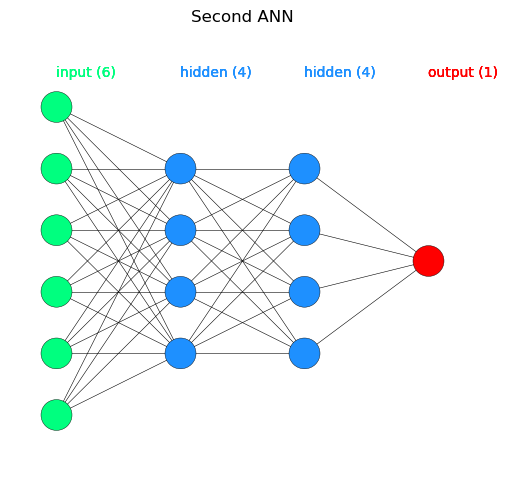

In [15]:
# display neural network topology
def visualize_neural_network(layer_sizes, title='ANN', figsize=(6, 6), description=True):
    
    # figure setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_title(label=title)
    ax.axis('off')
    
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)

    # plot nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2 + (top + bottom)/2
        layer = layer_sizes[n]
        # colors - output layer: red, input layer: green, other layers (hidden): blue
        if n in [len(layer_sizes) - 1]:
            color = 'red'
        elif n in [0, len(layer_sizes) - 1]:
            color = 'springgreen'
        else:
            color = 'dodgerblue'
        
        # circles
        for m in range(layer_size):
            circle = plt.Circle(xy=(n*h_spacing + left, layer_top - m*v_spacing), radius=v_spacing/4,
                                color=color, ec='black', lw=0.3, zorder=4)
            ax.add_artist(circle)
            
        # labels (description) - type of layer & number of neurons
        if description is True:
            plt.text(x=left, y=top, fontsize=10, color='springgreen', s='input ({})'.format(layer_sizes[0]))
            plt.text(x=right, y=top, fontsize=10, color='red', s='output ({})'.format(layer_sizes[-1]))
            for i in range(1, len(layer_sizes)-1):
                plt.text(x=left + i*h_spacing, y=top, fontsize=10, color='dodgerblue', s='hidden ({})'.format(layer_sizes[i]))
    
    # plot edges (links between nodes)
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2 + (top + bottom)/2
        layer_top_b = v_spacing*(layer_size_b - 1)/2 + (top + bottom)/2
        
        # links
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D(xdata=[n*h_spacing + left, (n + 1)*h_spacing + left], lw=0.4,
                                  ydata=[layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='black')
                ax.add_artist(line)
    plt.show()
    
visualize_neural_network(layer_sizes=[6, 4, 4, 1], title='Second ANN')